# Anharmonic frequency shifts of normal modes in five-wire trap

The following notebook presents calculatino of anharmonic modes of 5 ion crystal in a five-wire planar trap.

Contents:

1) five-wire trap initialization  
2) Simulation of 3 ions, single species  
3) Normal modes calculation  
4) Anharmonic modes calculation


In [1]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn

## Trap initialization

The following block initializes the n-wire trap - a planar trap with n parallel RF lines, which can influence anharmonicity and stability of the trap potential, using a *sion* function. The following parameters are optimized to maximize the anharmonicity for this geometry.

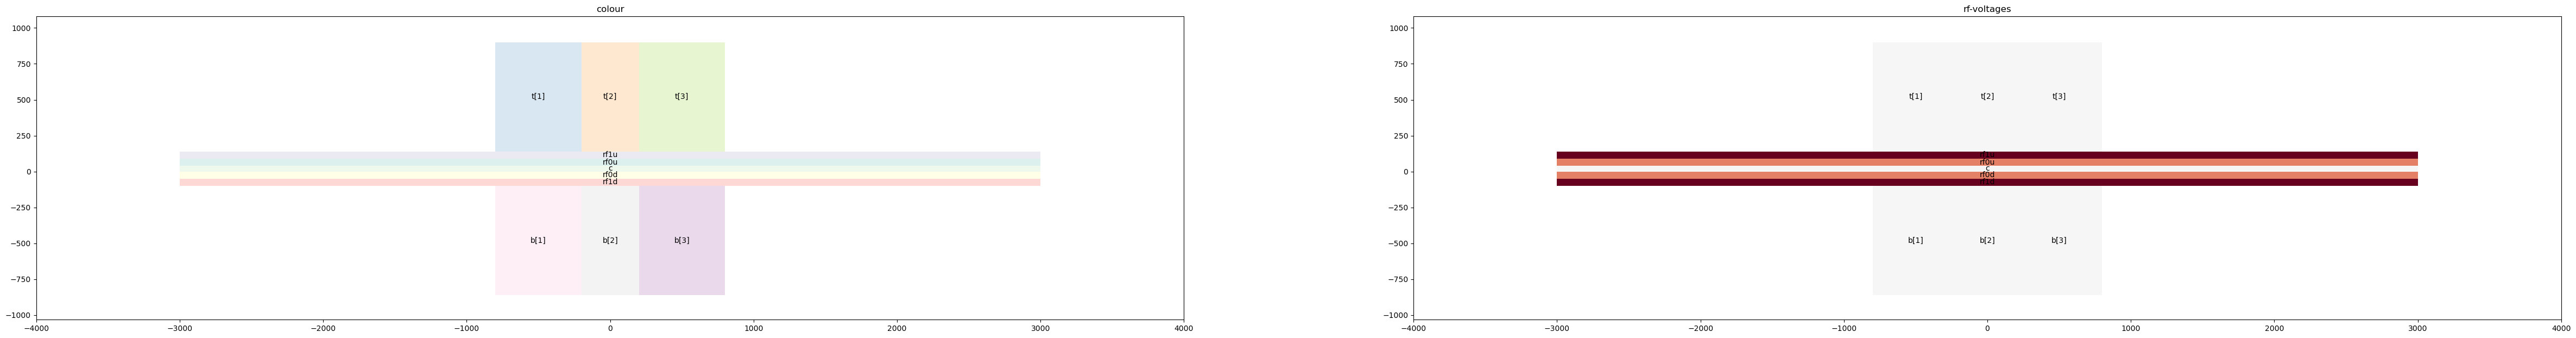

In [234]:
# define trap with large anharmonicity 
L = 1e-6 # length scale
Vrf = 100. # RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*70e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)


# parameters of trap
DCtop = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Top electrodes
DCbottom = [[760, 600],[1000-240, 400],[760, 600] ]  # Array of lengths and widths of Bottom electrodes
cwidth = 40  # Width of central dc electrode
clength = 6000 # length of central dc electrode
boardwidth = 10  # width of gaps between electrodes
rfwidth = np.array([[50, 50], [50, 50]])
rflength = 6000  # length of rf electrodes
n_rf = 2
Urf = [[Urf, Urf], [2*Urf, 2*Urf]]

#s, RF_electrodes, DC_electrodes = sn.five_wire_trap_design(Urf, DCtop, DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom, need_coordinates = True, need_plot = True)
s, RF_electrodes, DC_electrodes = sn.n_rf_trap_design(Urf, DCtop, DCbottom, cwidth, rfwidth, rflength, n_rf = n_rf , L = 1e-6, need_coordinates = True, need_plot = True)


## Trap potential analysis

The following block determines the trap minimum point and secular frequencies of ions in the trap. Additionally, the pseudopotential of the trap is presented on 3 plots, demonstrating the cross-sections of potential colormap through the trap minimum.

In [235]:
x0 = np.array(s.minimum((0., 0, 30), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
dc_set = 0.3*np.array([15, -15,  15, 15, -15, 15,  -3.408]) 

u_set = np.concatenate((np.zeros(2*n_rf), dc_set))

with s.with_voltages(dcs = u_set, rfs = None):
    x1 = np.array(s.minimum( x0, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
    print('Potential minimum:', x1)
    print('Distance from RF minimum:',x1-x0)
    curv_z, mod_dir=s.modes(x1,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("In directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )


Potential minimum: [1.21396244e-20 2.00000011e+01 5.94084633e+01]
Distance from RF minimum: [0. 0. 0.]
Secular frequencies: (1.16, 7.089, 7.139) MHz
In directions
a: [ 1. -0.  0.] 
b: [ 0.00000000e+00  1.00000000e+00 -4.09411212e-06] 
c: [0.00000000e+00 4.09411212e-06 1.00000000e+00]


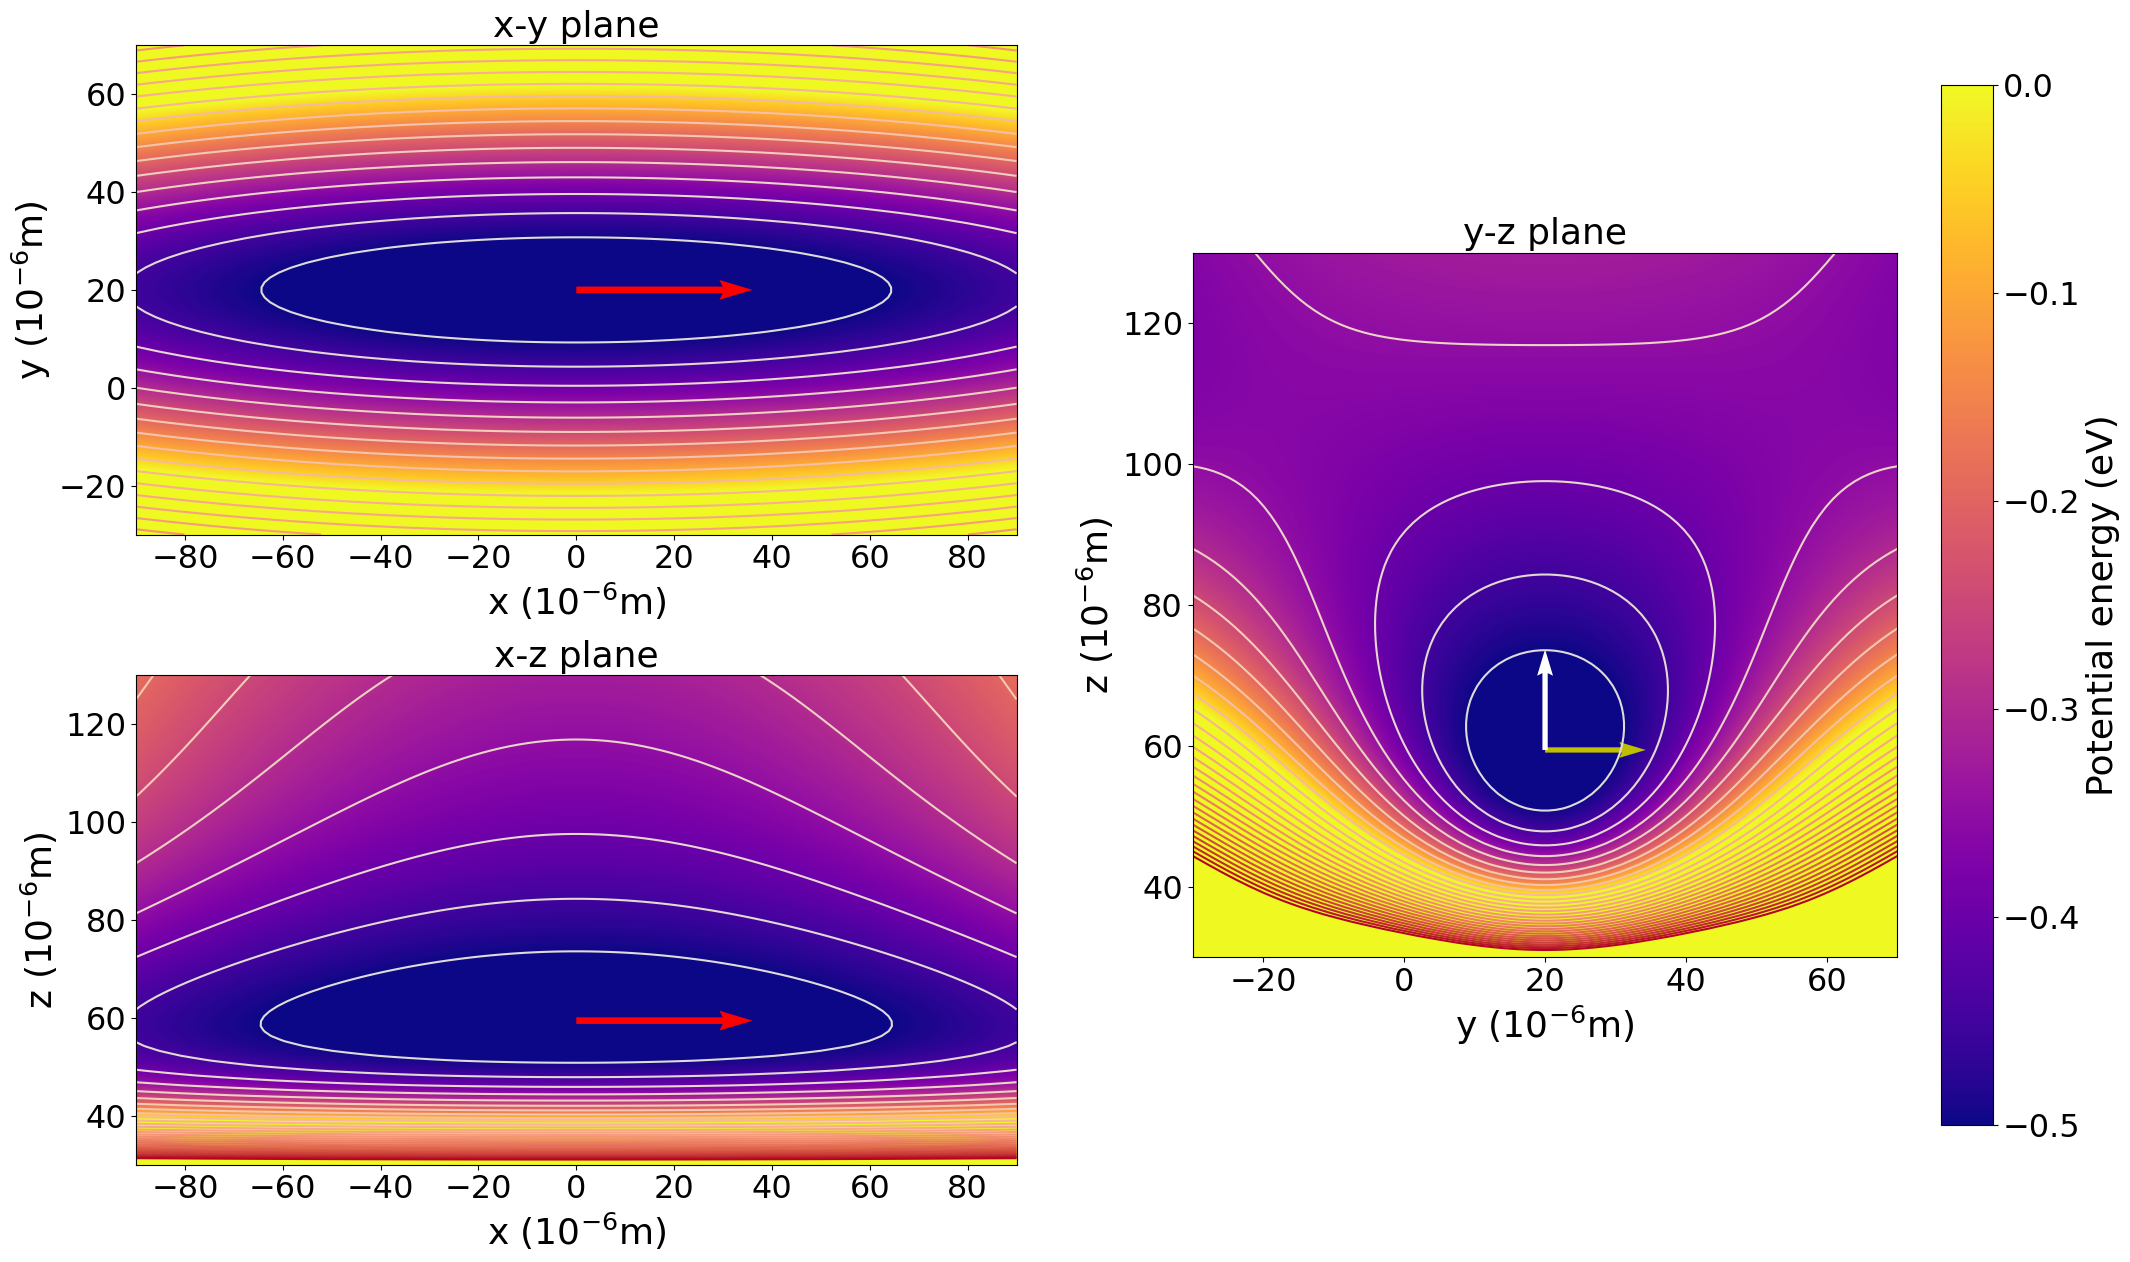

In [230]:
 # #Plot the pseudopotential
with s.with_voltages(dcs = u_set, rfs = None):
    # in with_voltages, all electrodes have to be listed in an array
    # (the array for dcs also contains the RF electrode)
    
    # 2D plot settings
    
    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -90, 90 #set the plot ranges
    ymin, ymax = -30, 70
    zmin, zmax = 30, 130
    x_cut, y_cut, z_cut = x0[0], x0[1], x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(-2, 1, 0.05)# set the range for contour lines (range in eV)
    v_min, v_max = -0.5, 0 # set the range for colour map (range in eV)
    fs = 26 #set the fontsize
    ls = 23 #set the labelsize
    fig = plt.figure()
    fig.set_size_inches(25,15)
    
    # x-y cross section
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax1.set_title("x-y plane" ,fontsize=fs)
    ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
    ax1.tick_params(axis='x', labelsize=ls)
    ax1.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
    pot = shaped(s.potential)(xyz)
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
    im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
    im.set_interpolation('bilinear')
    
    # x-z cross section
    ax2 = plt.subplot2grid((2,2), (1,0))
    ax2.set_title("x-z plane" ,fontsize=fs)
    ax2.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax2.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax2.tick_params(axis='x', labelsize=ls)
    ax2.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
    CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
    im.set_interpolation('bilinear')
    
    # y-z cross section
    ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
    ax3.set_title("y-z plane" ,fontsize=fs)
    ax3.set_xlabel('y ($10^{-6}$m)',fontsize=fs)
    ax3.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax3.tick_params(axis='x', labelsize=ls)
    ax3.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
    CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
    im.set_interpolation('bilinear') 
    
    # add colorbar
    cb = fig.colorbar(im, ax=ax3, shrink=0.9)
    cb.ax.tick_params(labelsize=ls)
    cb.set_label('Potential energy (eV)', fontsize = fs)
    
    #add secular frequencies
    #change color and scale (the fewer, the longer the arrow)
    ax1.quiver(*[[x0[0]],[x0[1]]], mod_dir[0][0], mod_dir[0][1], color=['r'], scale = 5)
    ax2.quiver(*[[x0[0]],[x0[2]]], mod_dir[0][0], mod_dir[0][2], color=['r'], scale = 5)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)

## Stability

To confirm, that ions will be stable in this potential configuration, the stability analysis is carried out.

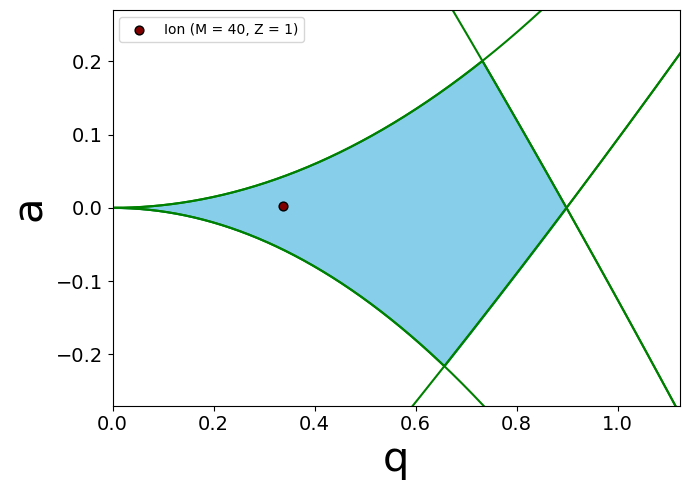

{'Ion (M = 40, Z = 1)': {'a': 0.0027590922767625503, 'q': 0.3382018225378601},
 'α': 1.3382908972971501,
 'θ': 0.0,
 'Range of achievable a': [-0.21589134726286627, 0.20045287243302598],
 'Critical q': 0.8989794855663561}


In [193]:
rf_set = [Vrf]*n_rf*2
with s.with_voltages(dcs = u_set, rfs = rf_set):
    params = sn.stability(s, mass, Omega, Z, minimum = x1) 

import pprint
pprint.pprint(params, sort_dicts=False)

## Anharmonic length

The surface trap potential is influenced by anharmonic terms, mostly hexapole and octopole anharmonicity. In 1D simplified picture, such effects can be expressed in terms of anharmonic length $l_2, l_3, l_4$. The potential is then modified as follows:

$ V(z) = \frac{\text{Z}e}{8\pi\epsilon_0l_2^3}z^2\left( 1 + \frac{z}{l_3} + \left(\frac{z}{l_4}\right) ^2 \right). $

Then, the anharmonic frequency shifts can be estimated through the relation of $\frac{l_2}{l_3} + \left(\frac{l_2}{l_4}\right) ^2 $. The *sion.anharmonics* function finds the anharmonic lengths for the considered trap configuration, for the desired axis of oscillation.

In [236]:
minimums = [x1]
axis = 2 # this is vertical z axis in this example 

with s.with_voltages(dcs = u_set, rfs = None):
    scales = sn.anharmonics(s, minimums, axis, L)
    
scales = scales[0]
print('l2 =', scales[0], '\nl3 =', scales[1], '\nl4 =', scales[2])

l2 = 1.1996508684278596e-06 
l3 = -7.503337689551785e-06 
l4 = 8.311653553931206e-06


## Ion dynamics simulation

Since the simulation considers the full potential expression, the resulting equilibrium ion positions are determined considering the effects of anharmonicity.

In [195]:
ion_number = 3

#insert your path to this file here
name = Path('anharmonic_modes.ipynb').stem

sim = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
positions = sn.ioncloud_min(x1*L, ion_number, 5e-6)
sim.append(pl.placeions(ions, positions))

#declaration of a five wire trap
sim.append(sn.polygon_trap([Omega,Omega,Omega,Omega], rf_set, dc_set, RF_electrodes, DC_electrodes))

#cooling simulation
sim.append(pl.langevinbath(0, 1e-7))

#files with simulation information
sim.append(pl.dump('anharmonic_positions.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(1e5))
sim.execute()

Reducing timestep to 1.1368210220849666e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  3 settings made for charge
3 atoms in group 1
3 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 1.13682e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step CPU 
       0   

C:\Users\User_A\anaconda3\lib\site-packages\pylion-0.5.2-py3.9.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


Final positions of ions:
 [[-4.58159e-06  2.00000e-05  4.86324e-05]
 [-1.16067e-19  2.00000e-05  4.86355e-05]
 [ 4.58159e-06  2.00000e-05  4.86324e-05]]


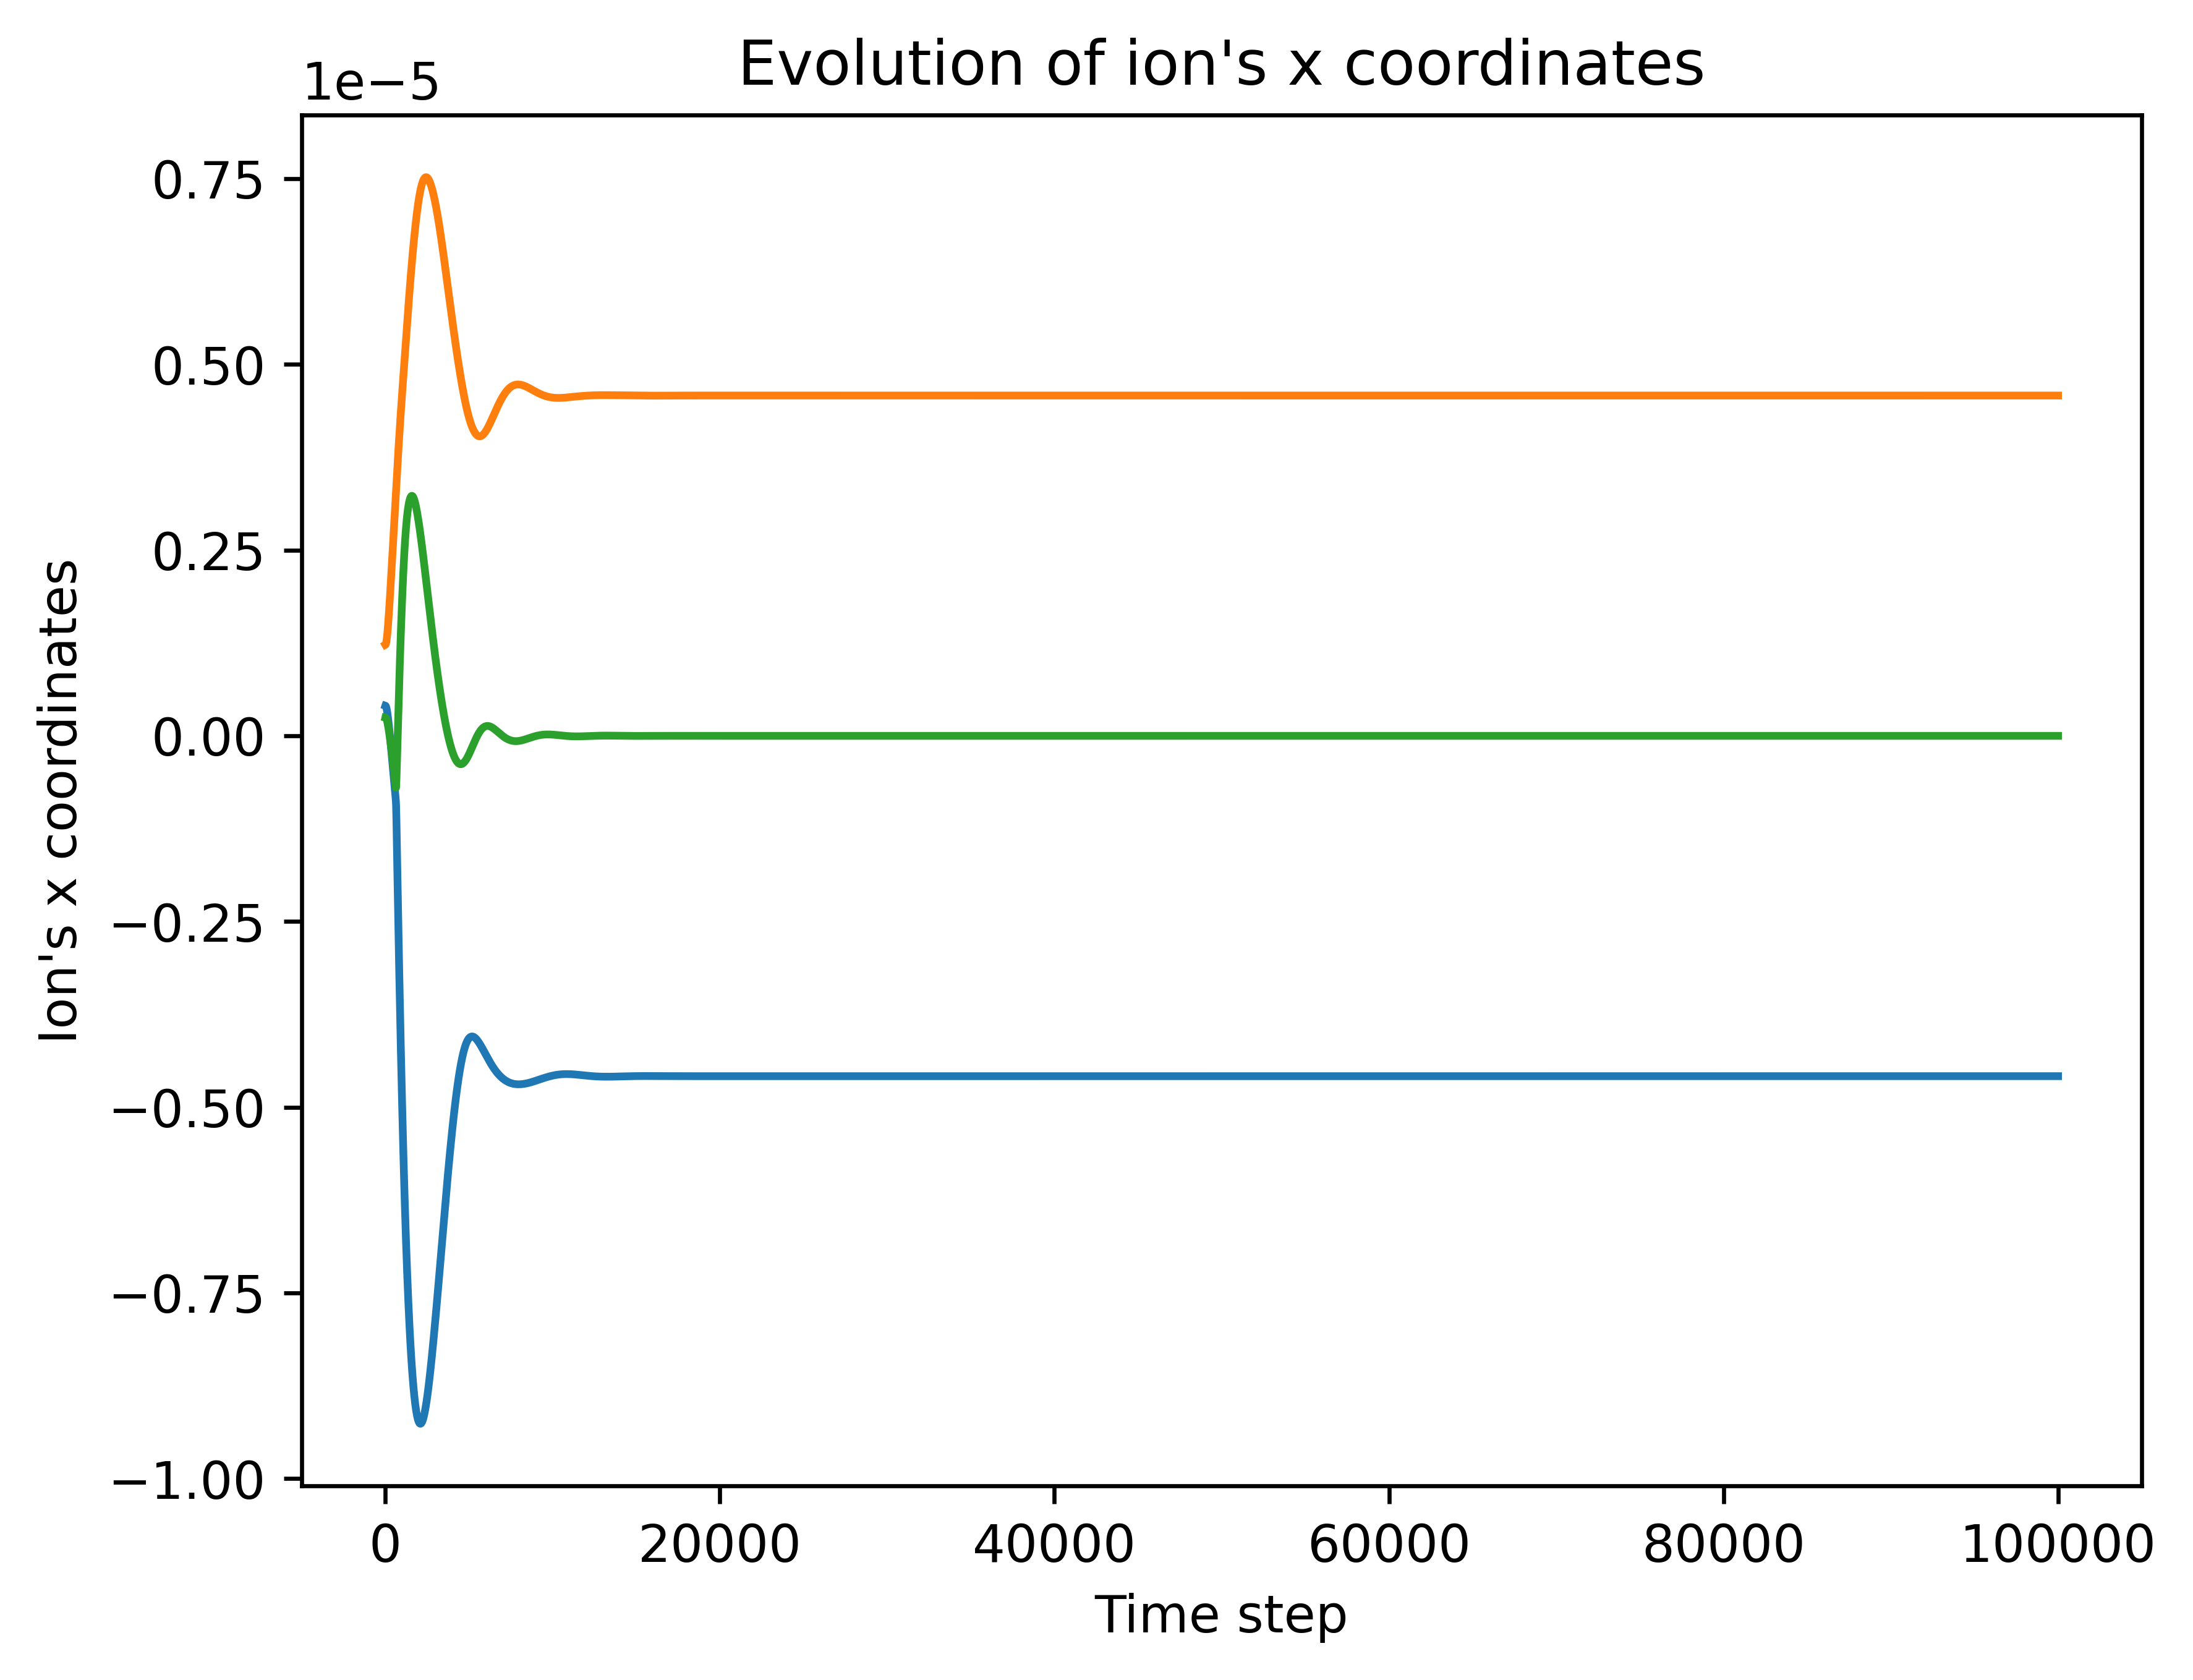

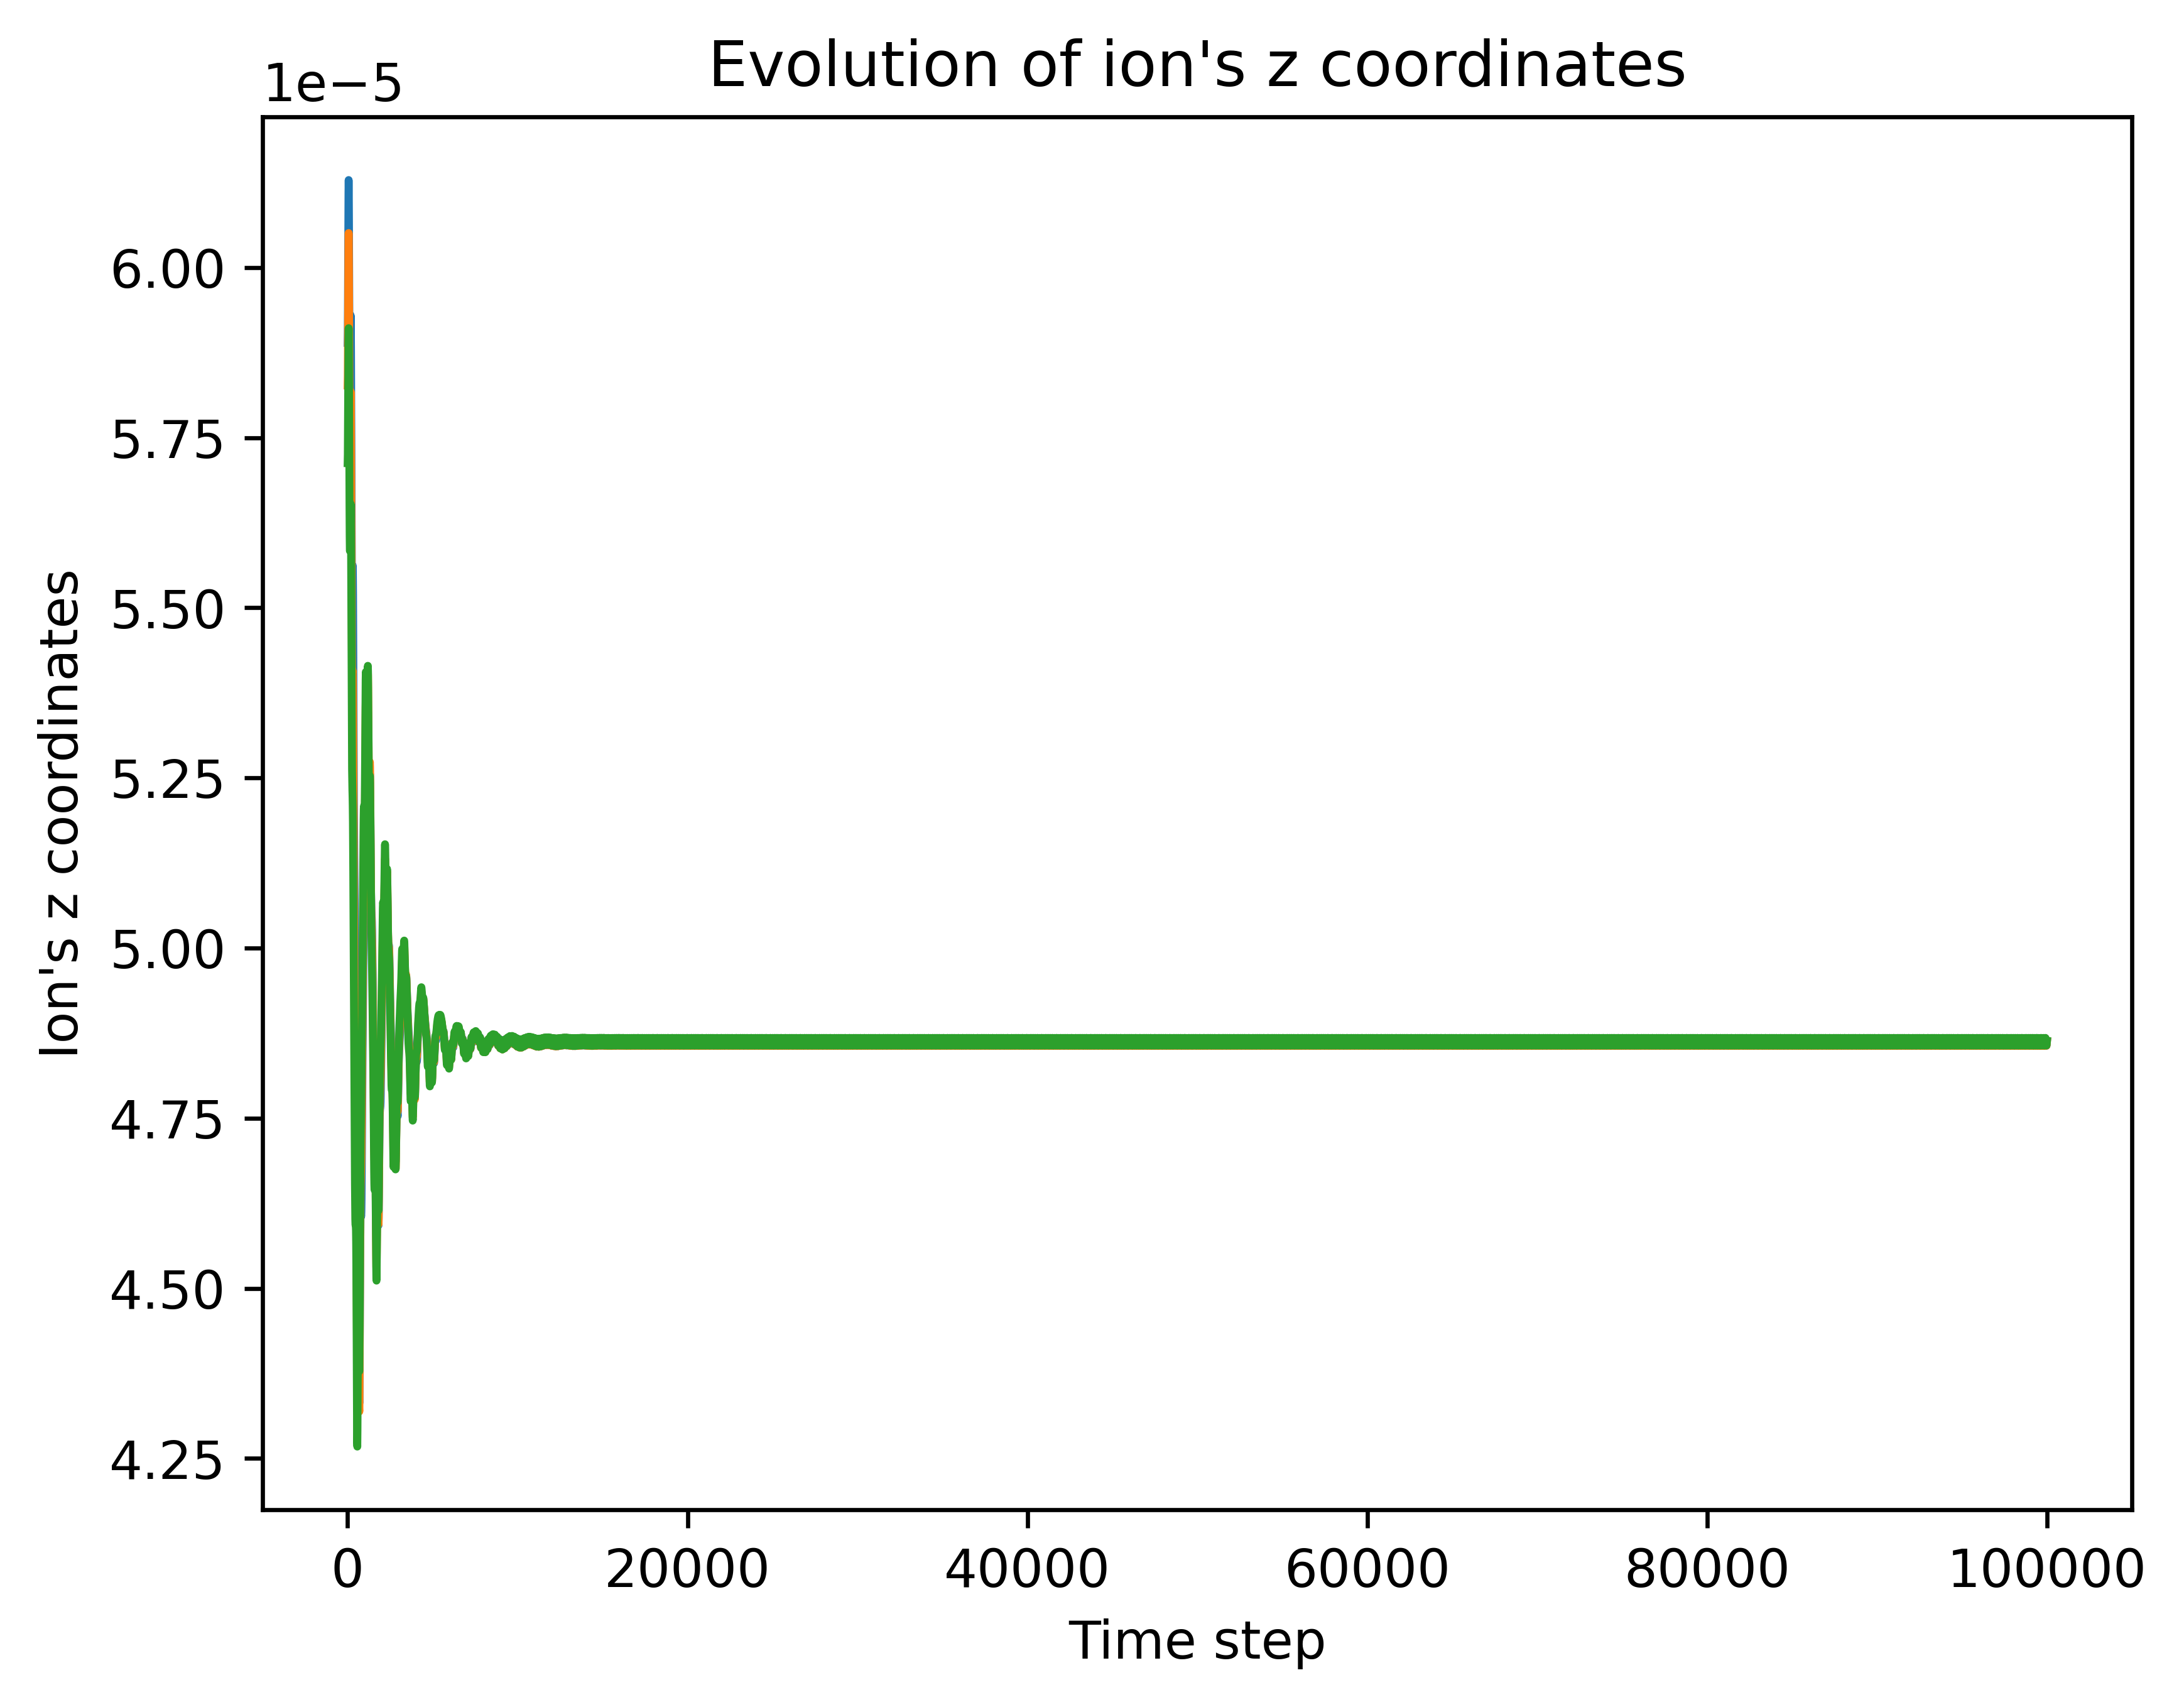

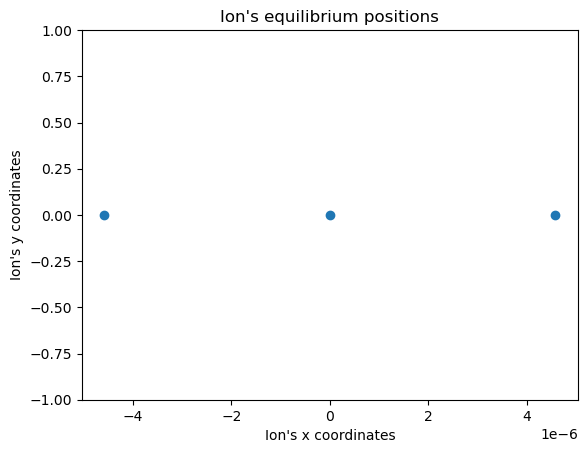

In [196]:
_, data = pl.readdump('anharmonic_positions.txt')

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

print('Final positions of ions:\n', ion_positions)


# Plot of ion crystal evolution
plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 2])
plt.title('Evolution of ion\'s z coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s z coordinates')
plt.show()

# Plot of the final ion crystal configuration
plt.figure()
plt.scatter(data[-1, :, 0], data[-1, :, 1])
plt.title('Ion\'s equilibrium positions')
plt.xlabel('Ion\'s x coordinates')
plt.ylabel('Ion\'s y coordinates')
plt.ylim([-max(1, 1.2 * np.max(np.abs(data[-1, :, 1]))), max(1, 1.2 * np.max(np.abs(data[-1, :, 1])))])
plt.show()


## Harmonic normal modes

Given the ion crystal coordinates, the *sion.normal_modes()* function returns the calculated normal modes in harmonic approximation. The following block calculates normal modes, corresponding to *z* principle axis.

In [216]:
omegas = np.array([omega_sec, omega_sec, omega_sec])*1e6  #convert to Hz
ion_masses = [mass, mass, mass]
harm_freqs, harm_modes = sn.normal_modes(ion_positions, omegas, ion_masses)
radial_freqs_z = []
radial_modes_z = []
for i in range(3*ion_number):
    k = np.argmax(np.abs(harm_modes[i]))
    if  k>=2*ion_number:
        radial_modes_z.append(harm_modes[i][2*ion_number:])
        radial_freqs_z.append(harm_freqs[i])

radial_freqs_z = np.array(radial_freqs_z)
print('Harmonic mode frequencies (MHz):\n','stretch:', np.round(radial_freqs_z[0]*1e-6, 2),', breathing:', np.round(radial_freqs_z[1]*1e-6, 2), ', COM:', np.round(radial_freqs_z[2]*1e-6, 2))
print('Harmonic mode vectors:')
print(f'stretch: {radial_modes_z[0]}')
print(f'breathing: {radial_modes_z[1]}')
print(f'COM: {radial_modes_z[2]}')

Harmonic mode frequencies (MHz):
 stretch: 6.94 , breathing: 7.06 , COM: 7.14
Harmonic mode vectors:
stretch: [-0.40824829  0.81649658 -0.40824829]
breathing: [ 7.07106779e-01  5.49266507e-14 -7.07106779e-01]
COM: [0.57735027 0.57735027 0.57735027]


## Anharmonic modes

Provided that the anharmonic terms are small, the modes can be still considered harmonic with some frequency shift, coming from anharmonic terms. The *sion.anharmonic_modes* function calculates the modes, corresponding to the harmonic ones with the frequency shift.

In [231]:
masses = [mass, mass, mass]
axis = 2
with s.with_voltages(dcs = u_set, rfs = None):
    freqs, modes = sn.anharmonic_modes(s, ion_positions, masses, axis)

print('Sion anharmonic mode frequencies (MHz):\n','1 (stretch):', np.round(freqs[0]*1e-6, 2),', 2 (breathing):', np.round(freqs[2]*1e-6, 2), ', 3 (COM):', np.round(freqs[1]*1e-6, 2))
print('Anharmonic mode vectors:')
print(f'1 (stretch): {modes[0]}')
print(f'2 (breathing): {modes[2]}')
print(f'3 (COM): {modes[1]}')
print('Frequency difference (MHz):\n','stretch:', np.round((radial_freqs_z[0]-freqs[0])*1e-6, 3),', breathing:', np.round((radial_freqs_z[1] - freqs[2])*1e-6, 3), ', COM:', np.round((radial_freqs_z[2]-freqs[1])*1e-6, 3))


Sion anharmonic mode frequencies (MHz):
 1 (stretch): 7.01 , 2 (breathing): 9.07 , 3 (COM): 9.08
Anharmonic mode vectors:
1 (stretch): [-0.02742934  0.99924735 -0.02742934]
2 (breathing): [ 7.07106781e-01  3.08806775e-12 -7.07106781e-01]
3 (COM): [0.70657458 0.03879095 0.70657458]
Frequency difference (MHz):
 stretch: -0.062 , breathing: -2.007 , COM: -1.942


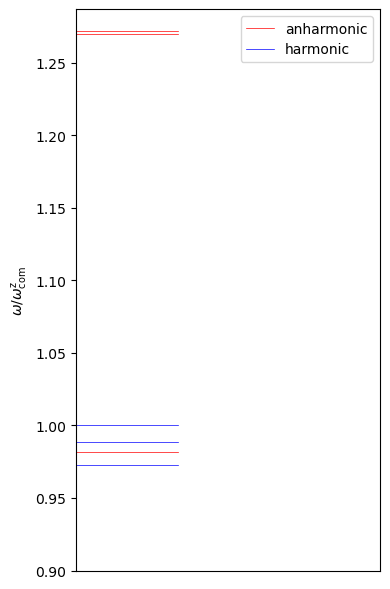

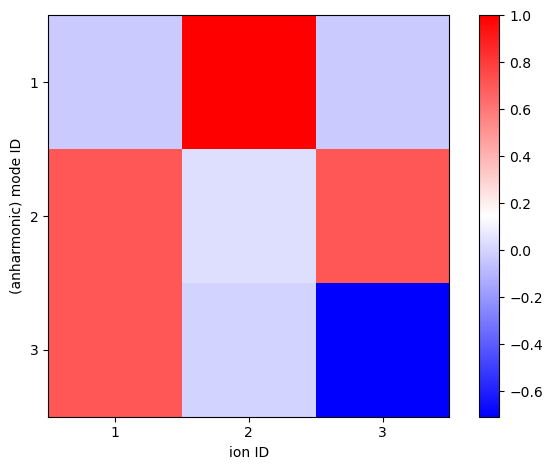

In [233]:
plt.figure(figsize=(4, 6))
plt.plot([], [], color='red', label='anharmonic', linewidth=0.5)
plt.plot([], [], color='blue', label='harmonic', linewidth=0.5)

for omega in freqs*1e-6:
    plt.plot([-1, 0], [omega / omega_sec[2], omega / omega_sec[2]], color='red', linewidth=0.5)
for omega in radial_freqs_z*1e-6:
    plt.plot([-1, 0], [omega / omega_sec[2], omega / omega_sec[2]], color='blue', linewidth=0.5)

plt.ylabel('$\omega/\omega_{\mathrm{com}}^{\mathrm{z}}$')
plt.xticks([])
plt.xlim(-1, 2)
plt.ylim(ymin=0.9)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

plt.figure()
plt.imshow(modes[:, :] / np.max(np.abs(modes)), cmap='bwr')
plt.colorbar()
plt.xticks([0, 1, 2], [1, 2, 3])
plt.yticks([0, 1, 2], [1, 2, 3])

plt.xlabel('ion ID')
plt.ylabel('(anharmonic) mode ID')
plt.tight_layout()
plt.show() 